# part 1: Diverse Dataset training

## IMPORTS

In [7]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


# FIX THE SEED: This ensures you get the exact same "random" numbers every time
np.random.seed(42)

## BLOCK 1: DIVERSE DATA GENERATION (The "27-Flavor" Dataset)

In [8]:
# =============================================================================
# BLOCK 1: DIVERSE DATA GENERATION (The "27-Flavor" Dataset)
# =============================================================================

# --- 1. CONFIGURATION ---
WINDOW_SIZE = 5
SYMBOLS_PER_BATCH = 1000  # Increased as you requested

# The 3x3x3 Grid
SNR_values = [20, 25, 30]        # Noisy -> Clean
CD_values = [0.1, 0.2, 0.3,0.3]     # Perfect -> Smeary
Gamma_values = [0.02, 0.03, 0.05,0.05]# Linear -> Twisted
phase_noise_strength = 0.0002  # Kept zero as per Phase 1 agreement

# Storage for our massive dataset
X_all_list = []
y_all_list = []

# --- 2. THE PHYSICS ENGINE (Function) ---
def simulate_channel(n_sym, snr, cd, gamma):
    # A. Transmitter
    points = np.array([-3, -1, 1, 3])
    constellation = np.array([r + 1j*i for r in points for i in points])
    tx_syms = constellation[np.random.randint(0, 16, n_sym)]
    
    # B. CD (Chromatic Dispersion)
    if cd > 0:
        # Impulse response: [Prev, Main, Next]
        h_cd = np.array([cd * 0.5j, 1.0 + 0j, cd * 0.5j])
        h_cd /= np.sqrt(np.sum(np.abs(h_cd)**2)) # Energy Norm
        rx_stage1 = np.convolve(tx_syms, h_cd, mode='same')
    else:
        rx_stage1 = tx_syms # Perfect bypass

    # C. Nonlinearity (Kerr)
    if gamma > 0:
        pwr = np.abs(rx_stage1)**2
        rx_stage2 = rx_stage1 * np.exp(1j * gamma * pwr)
    else:
        rx_stage2 = rx_stage1

    # D. Phase Noise (Keeping it 0 as agreed for Phase 1)
    random_phase_walk = np.cumsum(np.random.normal(0, phase_noise_strength, n_sym))
    rx_stage3 = rx_stage2 * np.exp(1j * random_phase_walk)

    # E. AWGN (Noise)
    sig_pwr = np.mean(np.abs(tx_syms)**2)
    noise_pwr = sig_pwr / (10**(snr/10.0))
    noise = np.sqrt(noise_pwr/2) * (np.random.randn(n_sym) + 1j * np.random.randn(n_sym))
    
    rx_final = rx_stage3 + noise
    return rx_final, tx_syms

# --- 3. THE GENERATION LOOP ---
print(f"Generating Dataset with {len(SNR_values)*len(CD_values)*len(Gamma_values)} combinations...")

batch_count = 0
for snr in SNR_values:
    for cd in CD_values:
        for gamma in Gamma_values:
            # 1. Generate Raw Physics for this specific condition
            rx_raw, tx_raw = simulate_channel(SYMBOLS_PER_BATCH, snr, cd, gamma)
            
            # 2. Slice into Windows immediately (Prepare Data)
            # We use the logic from your old 'prepare_data' function right here
            X_batch = []
            y_batch = []
            pad = WINDOW_SIZE // 2
            
            for i in range(pad, len(rx_raw) - pad):
                # Input: The Window
                window = rx_raw[i-pad : i+pad+1]
                # Flatten: [Real1, Real2.., Imag1, Imag2..]
                feat = np.concatenate([window.real, window.imag])
                X_batch.append(feat)
                
                # Target: The Clean Center Symbol
                center_sym = tx_raw[i] # The Target is ALWAYS the clean transmitted symbol
                y_batch.append([center_sym.real, center_sym.imag])

            # 3. Add to the Master List
            X_all_list.append(np.array(X_batch))
            y_all_list.append(np.array(y_batch))
            batch_count += 1

# --- 4. MERGE & SHUFFLE ---
# Concatenate all 27 batches into one giant array
X_data = np.vstack(X_all_list)
y_data = np.vstack(y_all_list)

print(f"Generation Complete!")
print(f"Total Samples: {X_data.shape[0]}")

# --- 5. SCALING (Dynamic) ---
# We find the global max across the entire diverse dataset
# max_val = np.max(np.abs(X_data))
max_val = 5
print(f"Global Scaling Factor: {max_val:.4f}")

X_data_scaled = X_data / max_val
y_data_scaled = y_data / max_val

# --- 6. SPLIT ---
# Shuffle=True is CRITICAL here so the NN sees a mix of Easy/Hard cases in every batch
X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, y_data_scaled, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

# SAVE DATASET: Save arrays and the scaling factor to a single compressed file
np.savez('optical_dataset.npz', 
         X_data=X_data_scaled,  # Save the SCALED version to save time later
         y_data=y_data_scaled, 
         max_val=max_val)

print("Dataset saved to 'optical_dataset.npz'.")
print("Dataset is ready for Robust Training.")

Generating Dataset with 48 combinations...
Generation Complete!
Total Samples: 47808
Global Scaling Factor: 5.0000
Dataset saved to 'optical_dataset.npz'.
Dataset is ready for Robust Training.


## BLOCK 1.5: VISUAL CHECK (The "27-Flavor" Checkup)

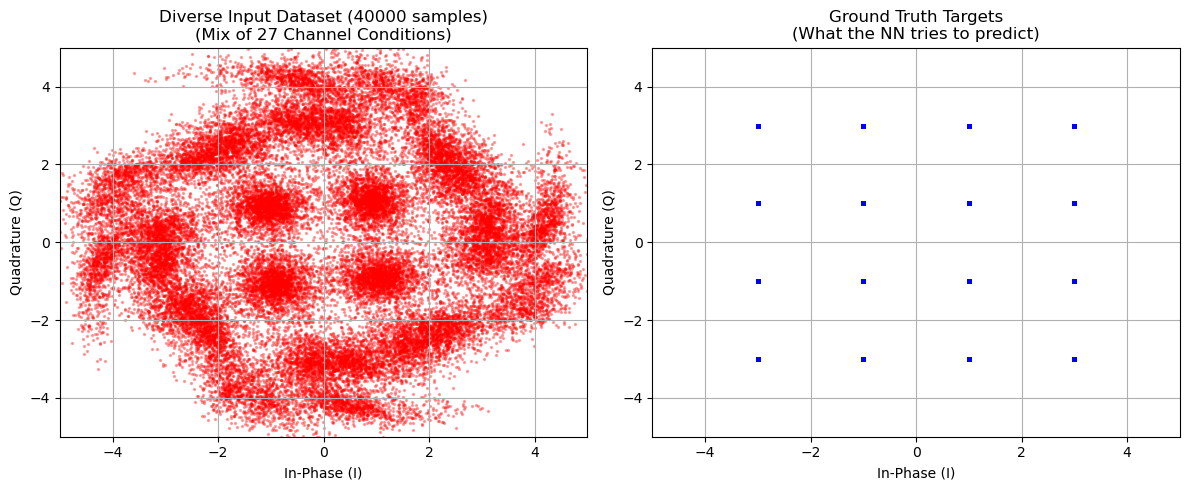

Observation Guide:
1. If the Red Plot looks like a 'Fuzzy Blob' with a darker center: That is GOOD.
   It means you have a mix of Clean signals (center) and Noisy/Spiraled signals (edges).
2. If the Blue Plot is 16 perfect dots: Your target generation is correct.


In [9]:
# =============================================================================
# BLOCK 1.5: VISUAL CHECK (The "27-Flavor" Checkup)
# =============================================================================

# 1. Un-Scale a small batch for plotting
# We only plot 5,000 points so the graph doesn't crash your browser
N_PLOT = 40000 
subset_X = X_train[:N_PLOT]
subset_y = y_train[:N_PLOT]

# 2. Extract the CENTER Symbol from the Window
# Window layout: [Real0, Real1, Real2, Real3, Real4, Imag0, Imag1, Imag2, Imag3, Imag4]
# The Center Symbol is at index 2 (Real) and 7 (Imag)
rx_center_real = subset_X[:, 2] * max_val
rx_center_imag = subset_X[:, 7] * max_val
rx_complex = rx_center_real + 1j * rx_center_imag

# 3. Extract the Target Symbol
tx_real = subset_y[:, 0] * max_val
tx_imag = subset_y[:, 1] * max_val
tx_complex = tx_real + 1j * tx_imag

# 4. Plot
plt.figure(figsize=(12, 5))

# Plot A: The Messy Input (The "Problem")
plt.subplot(1, 2, 1)
plt.scatter(rx_complex.real, rx_complex.imag, s=2, alpha=0.3, c='red')
plt.title(f"Diverse Input Dataset ({N_PLOT} samples)\n(Mix of 27 Channel Conditions)")
plt.xlabel("In-Phase (I)"); plt.ylabel("Quadrature (Q)")
plt.grid(True)
plt.xlim(-5, 5); plt.ylim(-5, 5)

# Plot B: The Clean Target (The "Goal")
plt.subplot(1, 2, 2)
plt.scatter(tx_complex.real, tx_complex.imag, s=5, alpha=0.6, c='blue')
plt.title("Ground Truth Targets\n(What the NN tries to predict)")
plt.xlabel("In-Phase (I)"); plt.ylabel("Quadrature (Q)")
plt.grid(True)
plt.xlim(-5, 5); plt.ylim(-5, 5)

plt.tight_layout()
plt.show()

print("Observation Guide:")
print("1. If the Red Plot looks like a 'Fuzzy Blob' with a darker center: That is GOOD.")
print("   It means you have a mix of Clean signals (center) and Noisy/Spiraled signals (edges).")
print("2. If the Blue Plot is 16 perfect dots: Your target generation is correct.")

## BLOCK 2: MODEL ARCHITECTURE (Fixed Syntax)

       [ INPUT LAYER ]             [ HIDDEN LAYER 1 ]          [ HIDDEN LAYER 2 ]          [ OUTPUT ]
      (The Context Window)        (Feature Extraction)        (Non-linear Solving)       (Clean Symbol)

          (Re_t-2) ● ───┐
          (Re_t-1) ● ───┤
          (Re_t) ● ───┤             ● (N_1)                     ● (N_1)
          (Im_t+1) ● ───┤           /   \                       /   \
          (Re_t+2)   ● ───┼───────── ● (N_2) ─────────────────── ● (N_2) ─────────────── ● (Real_Out)
          (Im_t-2)   ● ───┤           \   /                       \   /                    \
          (Im_t-1) ● ───┤             ● (N_3)                     ● (N_3)                 ● (Imag_Out)
          (Im_t) ● ───┤             .                           .
          (Im_t+1) ● ───┤             .                           .
          (Im_t+2) ● ───┘             ● (N_32)                    ● (N_32)

      [10 Neurons]               [32 Neurons]                [32 Neurons]               [2 Neurons]
      Raw Noisy Data              tanh activation             tanh activation             Linear

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,474 (5.76 KB)

 Trainable params: 1,474 (5.76 KB)

 Non-trainable params: 0 (0.00 B)

Model Configured: ReLU Activation (Hardware Compatible).


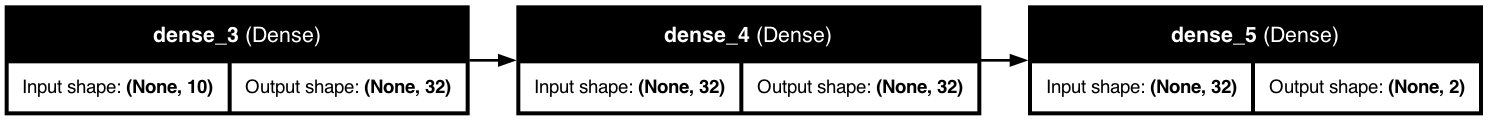

In [10]:
# =============================================================================
# BLOCK 2: MODEL ARCHITECTURE (Fixed Syntax)
# =============================================================================

# --- OLD CONFIGURATION (Tanh) ---
# # Define the Model
# model = Sequential([
#     # 1. Explicit Input Layer
#     Input(shape=(WINDOW_SIZE * 2,)), 
    
#     # 2. Hidden Layer 1: 32 Neurons
#     # Note: kernel_regularizer is INSIDE the parentheses now
#     Dense(32, activation='tanh', kernel_regularizer=l2(REG_STRENGTH)), 
    
#     # 3. Hidden Layer 2: 32 Neurons
#     Dense(32, activation='tanh', kernel_regularizer=l2(REG_STRENGTH)),
    
#     # 4. Output Layer: 2 Neurons (Predicted I & Q)
#     Dense(2, activation='linear', kernel_regularizer=l2(REG_STRENGTH)) 
# ])


# --- CONFIGURATION ---
REG_STRENGTH = 0.000004 # Keep it gentle so we don't kill the signal

model = Sequential([
    # Input Layer
    Input(shape=(WINDOW_SIZE * 2,)), 
    
    # Hidden Layer 1: ReLU (Cheap in Hardware)
    Dense(32, activation='relu',kernel_initializer='he_normal' ,kernel_regularizer=l2(REG_STRENGTH)), 
    
    # Hidden Layer 2: ReLU
    Dense(32, activation='relu',kernel_initializer='he_normal', kernel_regularizer=l2(REG_STRENGTH)),
    
    # Output Layer: Linear (Must be linear to output voltages like -3.0)
    Dense(2, activation='linear', kernel_regularizer=l2(REG_STRENGTH)) 
])

model.compile(optimizer='adam', loss='mse')
model.summary()
print("Model Configured: ReLU Activation (Hardware Compatible).")

# Plot the architecture
plot_model(model, 
           to_file='my_equalizer_architecture.png', 
           show_shapes=True, 
           show_layer_names=True,
           rankdir='LR',
           dpi=96)




## BLOCK 3: TRAINING  (old)

In [11]:
# =============================================================================
# BLOCK 3: TRAINING & VISUALIZATION (CORRECTED)
# =============================================================================

# # 1. Train
# print("Starting Training...")
# history = model.fit(X_train, y_train, 
#                     epochs=2000,           
#                     batch_size=32,       
#                     validation_split=0.1, 
#                     verbose=0) # Sshh, less noise



# # SAVE MODEL: Save weights, architecture, and optimizer state
# model.save('my_equalizer_model.keras')
# print("Model saved to 'my_equalizer_model.keras'.")


## BLOCK 3: TRAINING & VISUALIZATION (optimized)

Starting Training...
Epoch 1/1000
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.0690 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 2/1000
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0150 - val_loss: 0.0124 - learning_rate: 0.0010
Epoch 3/1000
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0116 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 4/1000
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0092 - val_loss: 0.0076 - learning_rate: 0.0010
Epoch 5/1000
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0073 - val_loss: 0.0061 - learning_rate: 0.0010
Epoch 6/1000
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0058 - val_loss: 0.0053 - learning_rate: 0.0010
Epoch 7/1000
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0052 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 8/1000
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0046 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 9/1000
1196/1196 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0

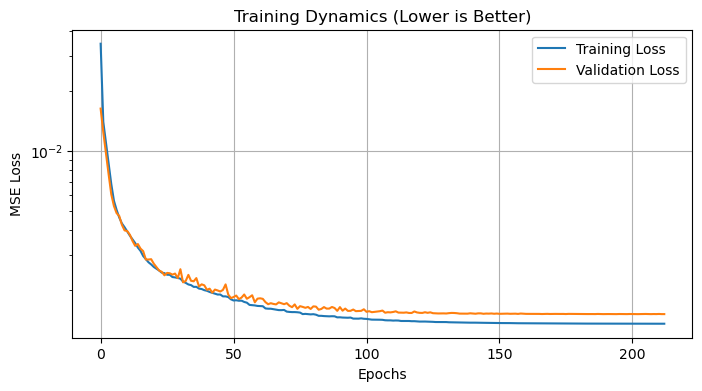

In [12]:
# =============================================================================
# BLOCK 3: OPTIMIZED TRAINING (With Schedulers)
# =============================================================================

# 1. Define Callbacks
# A. Stop if we stop improving (prevents overfitting)
early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    restore_best_weights=True,
    verbose=1
)

# B. Slow down if we get stuck (fine-tuning)
lr_decay = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.8,
    patience=6,
    min_lr=1e-6,
    verbose=1
)

# 2. Train
print("Starting Training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=1000,           # Set high, let EarlyStopping decide when to quit
    batch_size=32,        # Good balance of speed and noise
    callbacks=[early_stop, lr_decay],
    verbose=1
)

# 3. Save the Model
model.save('my_equalizer_model.keras')
print("Model Saved.")

# 4. Plot Learning Curve (Loss)
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training Dynamics (Lower is Better)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.yscale('log') # Log scale helps see the small improvements at the end
plt.show()

## BLOCK 4: VISUALIZATION

Running Inference...
299/299 ━━━━━━━━━━━━━━━━━━━━ 0s 597us/step


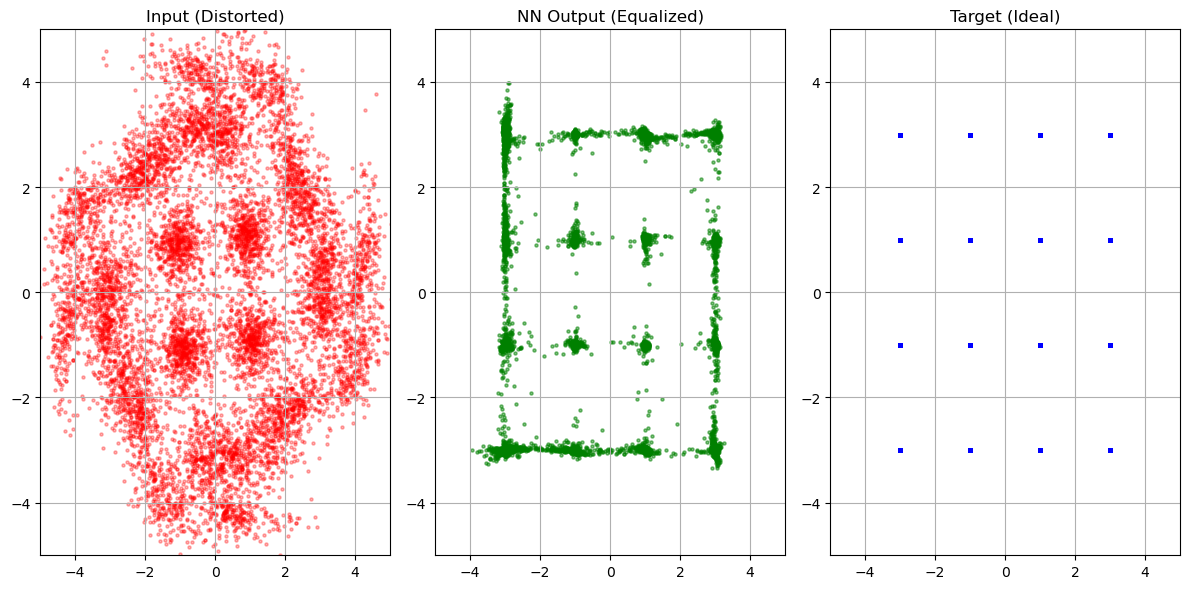

MSE Before Equalization: 3.3983
MSE After Equalization:  0.0551
Improvement Factor:      61.65x


In [37]:
# 2. Predict (Inference)
print("Running Inference...")
y_pred_scaled = model.predict(X_test)

# --- CRITICAL FIX: UN-SCALE THE OUTPUT ---
# We divided by 4 earlier. Now we multiply by 4 to get back to -3..+3 range.
SCALE_FACTOR = max_val
y_pred_real = y_pred_scaled * SCALE_FACTOR 

# Reconstruct Complex Numbers for Plotting
y_pred_complex = y_pred_real[:, 0] + 1j * y_pred_real[:, 1]
y_target_complex = y_test[:, 0] * SCALE_FACTOR + 1j * y_test[:, 1] * SCALE_FACTOR 
# Note: y_test was also scaled, so we un-scale it too for the plot comparison



# 3. VISUALIZATION
plt.figure(figsize=(12, 6))

# Plot 1: Input (What the NN saw)
# We take the center sample from X_test and un-scale it
center_real = X_test[:, 2] * SCALE_FACTOR
center_imag = X_test[:, 7] * SCALE_FACTOR
rx_center_complex = center_real + 1j * center_imag

plt.subplot(1, 3, 1)
plt.scatter(rx_center_complex.real, rx_center_complex.imag, c='red', s=5, alpha=0.3)
plt.title("Input (Distorted)")
plt.grid(True); plt.xlim(-5, 5); plt.ylim(-5, 5)

# Plot 2: NN Output (Equalized)
plt.subplot(1, 3, 2)
plt.scatter(y_pred_complex.real, y_pred_complex.imag, c='green', s=5, alpha=0.5)
plt.title("NN Output (Equalized)")
plt.grid(True); plt.xlim(-5, 5); plt.ylim(-5, 5)

# Plot 3: Target (Ideal)
plt.subplot(1, 3, 3)
plt.scatter(y_target_complex.real, y_target_complex.imag, c='blue', s=5, alpha=0.5)
plt.title("Target (Ideal)")
plt.grid(True); plt.xlim(-5, 5); plt.ylim(-5, 5)

plt.tight_layout()
plt.show()

# 4. MSE Calculation (On Real World Values)
input_mse = np.mean(np.abs(y_target_complex - rx_center_complex)**2)
output_mse = np.mean(np.abs(y_target_complex - y_pred_complex)**2)

print(f"MSE Before Equalization: {input_mse:.4f}")
print(f"MSE After Equalization:  {output_mse:.4f}")
print(f"Improvement Factor:      {input_mse/output_mse:.2f}x")

## BLOCK 5: THE ULTIMATE BENCHMARK (Linear MMSE & Baseline vs. NN)

Model loaded successfully.
Data loaded. Global Max Val: 5.0000
Computing Linear MMSE (Wiener Filter)...
Computing Baseline Slicer (Raw Channel)...

FINAL PROJECT RESULTS (Symbol Error Rate)
1. Baseline (Raw Input):   0.93819 (93.8%)
2. Linear MMSE (DSP):      0.14673 (14.7%)
3. Neural Network (You):   0.00994 (1.0%)


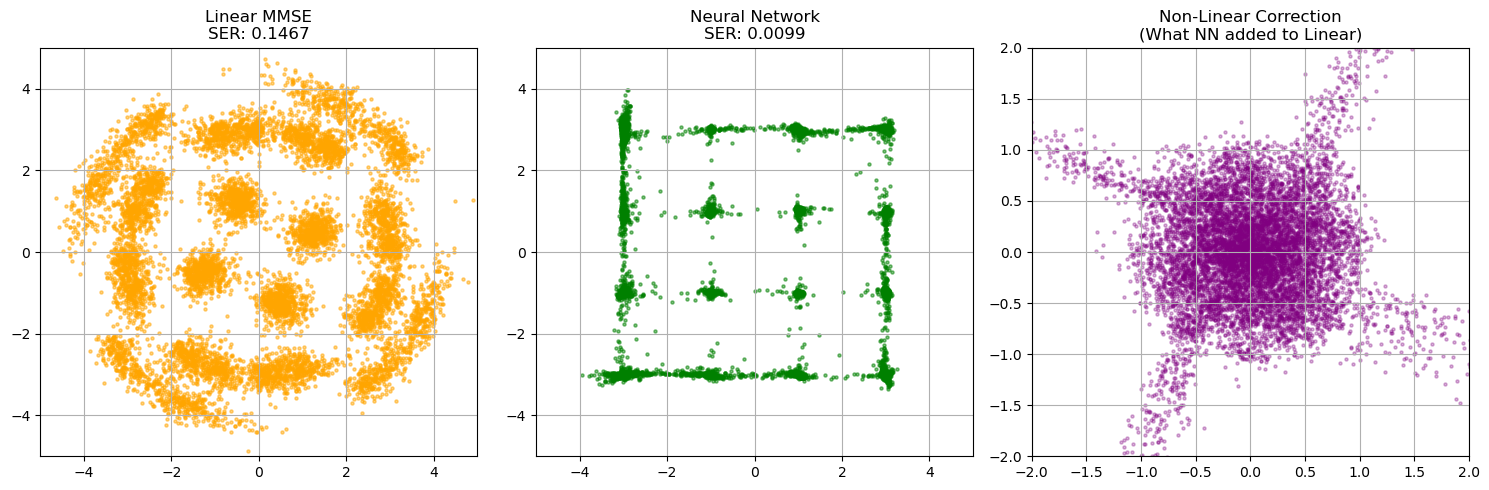

In [38]:
# =============================================================================
# BLOCK 5: THE ULTIMATE BENCHMARK (Linear MMSE & Baseline vs. NN)
# =============================================================================


# 1. LOAD THE MODEL
# This replaces Block 2 (Define) and Block 3 (Train)
model = load_model('my_equalizer_model.keras')
print("Model loaded successfully.")

# 2. LOAD THE DATA (Optional - if you skipped Block 1)
# This replaces the generation loop
data_pack = np.load('optical_dataset.npz')
X_data_scaled = data_pack['X_data']
y_data_scaled = data_pack['y_data']
max_val = float(data_pack['max_val']) # Important: Cast to float

# 3. RE-SPLIT
# We split again so X_test matches what you trained on (Seed 42 is critical here)
X_train, X_test, y_train, y_test = train_test_split(X_data_scaled, y_data_scaled, 
                                                    test_size=0.2, 
                                                    shuffle=True, 
                                                    random_state=42)

print(f"Data loaded. Global Max Val: {max_val:.4f}")

# --- Helper: Symbol De-mapper (Convert Complex -> Integer ID 0..15) ---
# We need this to count "Bit Errors" (or Symbol Errors) accurately
def get_symbol_id(complex_data):
    # Hard-coded thresholds for 16-QAM [-3, -1, 1, 3]
    # We slice at [-2, 0, 2]
    thresholds = np.array([-2, 0, 2])
    
    # Real part ID (0, 1, 2, 3)
    re_id = np.digitize(complex_data.real, thresholds)
    # Imag part ID (0, 1, 2, 3)
    im_id = np.digitize(complex_data.imag, thresholds)
    
    return re_id * 4 + im_id

# --- 1. Linear MMSE (The Theoretical Linear Limit) ---
print("Computing Linear MMSE (Wiener Filter)...")
# Scikit-Learn's LinearRegression mathematically solves the Wiener equation:
# W_opt = (R_xx)^-1 * R_xy
# This gives the BEST possible result obtainable by ANY linear filter.
linear_mmse = LinearRegression()
linear_mmse.fit(X_train, y_train)

# Predict using Linear MMSE
y_pred_lmmse_scaled = linear_mmse.predict(X_test)
y_pred_lmmse = y_pred_lmmse_scaled * SCALE_FACTOR
y_pred_lmmse_complex = y_pred_lmmse[:,0] + 1j * y_pred_lmmse[:,1]

# --- 2. Baseline MLD (The "Slicer" / No-Equalizer) ---
print("Computing Baseline Slicer (Raw Channel)...")
# Just take the center received sample and map it to nearest grid point
# X_test has 10 columns. Index 4 is Real(t), Index 9 is Imag(t)
rx_center_real = X_test[:, 4] * SCALE_FACTOR
rx_center_imag = X_test[:, 9] * SCALE_FACTOR
y_pred_slicer_complex = rx_center_real + 1j * rx_center_imag

# --- 3. Calculate Error Rates (SER) ---
# Ground Truth
y_test_real = y_test[:, 0] * SCALE_FACTOR
y_test_imag = y_test[:, 1] * SCALE_FACTOR
y_true_complex = y_test_real + 1j * y_test_imag
true_ids = get_symbol_id(y_true_complex)

# A. Baseline SER
pred_ids_slicer = get_symbol_id(y_pred_slicer_complex)
ser_slicer = np.mean(true_ids != pred_ids_slicer)

# B. Linear MMSE SER
pred_ids_lmmse = get_symbol_id(y_pred_lmmse_complex)
ser_lmmse = np.mean(true_ids != pred_ids_lmmse)

# C. Neural Network SER (From your previous Block 3 prediction)
# (Assuming y_pred_complex exists from previous block)
pred_ids_nn = get_symbol_id(y_pred_complex)
ser_nn = np.mean(true_ids != pred_ids_nn)

# --- 4. PRINT THE FINAL SCORECARD ---
print(f"\n{'='*45}")
print(f"FINAL PROJECT RESULTS (Symbol Error Rate)")
print(f"{'='*45}")
print(f"1. Baseline (Raw Input):   {ser_slicer:.5f} ({(ser_slicer*100):.1f}%)")
print(f"2. Linear MMSE (DSP):      {ser_lmmse:.5f} ({(ser_lmmse*100):.1f}%)")
print(f"3. Neural Network (You):   {ser_nn:.5f} ({(ser_nn*100):.1f}%)")
print(f"{'='*45}")

# --- 5. Visual Comparison Plot ---
plt.figure(figsize=(15, 5))

# Plot 1: Linear MMSE (The Competitor)
plt.subplot(1, 3, 1)
plt.scatter(y_pred_lmmse_complex.real, y_pred_lmmse_complex.imag, c='orange', s=5, alpha=0.5)
plt.title(f"Linear MMSE\nSER: {ser_lmmse:.4f}")
plt.grid(True); plt.xlim(-5, 5); plt.ylim(-5, 5)

# Plot 2: Neural Network (The Winner)
plt.subplot(1, 3, 2)
plt.scatter(y_pred_complex.real, y_pred_complex.imag, c='green', s=5, alpha=0.5)
plt.title(f"Neural Network\nSER: {ser_nn:.4f}")
plt.grid(True); plt.xlim(-5, 5); plt.ylim(-5, 5)

# Plot 3: Difference (Residuals)
# What did the NN fix that Linear missed?
residuals = y_pred_complex - y_pred_lmmse_complex
plt.subplot(1, 3, 3)
plt.scatter(residuals.real, residuals.imag, c='purple', s=5, alpha=0.3)
plt.title("Non-Linear Correction\n(What NN added to Linear)")
plt.grid(True); plt.xlim(-2, 2); plt.ylim(-2, 2)

plt.tight_layout()
plt.show()

## BLOCK 6: CHARACTERIZATION (Generating SER vs. SNR & SER vs. Gamma Curves)

Starting SNR Sweep (Fixed Gamma=0.03, CD=0.15)...
  SNR=14dB -> Base: 0.939, L-MMSE: 0.164, NN: 0.105
  SNR=16dB -> Base: 0.936, L-MMSE: 0.115, NN: 0.048
  SNR=18dB -> Base: 0.936, L-MMSE: 0.075, NN: 0.016
  SNR=20dB -> Base: 0.937, L-MMSE: 0.049, NN: 0.007
  SNR=22dB -> Base: 0.933, L-MMSE: 0.017, NN: 0.004
  SNR=24dB -> Base: 0.935, L-MMSE: 0.008, NN: 0.002
  SNR=26dB -> Base: 0.932, L-MMSE: 0.006, NN: 0.000
  SNR=28dB -> Base: 0.935, L-MMSE: 0.002, NN: 0.000
  SNR=30dB -> Base: 0.945, L-MMSE: 0.000, NN: 0.000

Starting Gamma Sweep (Fixed SNR=28dB)...


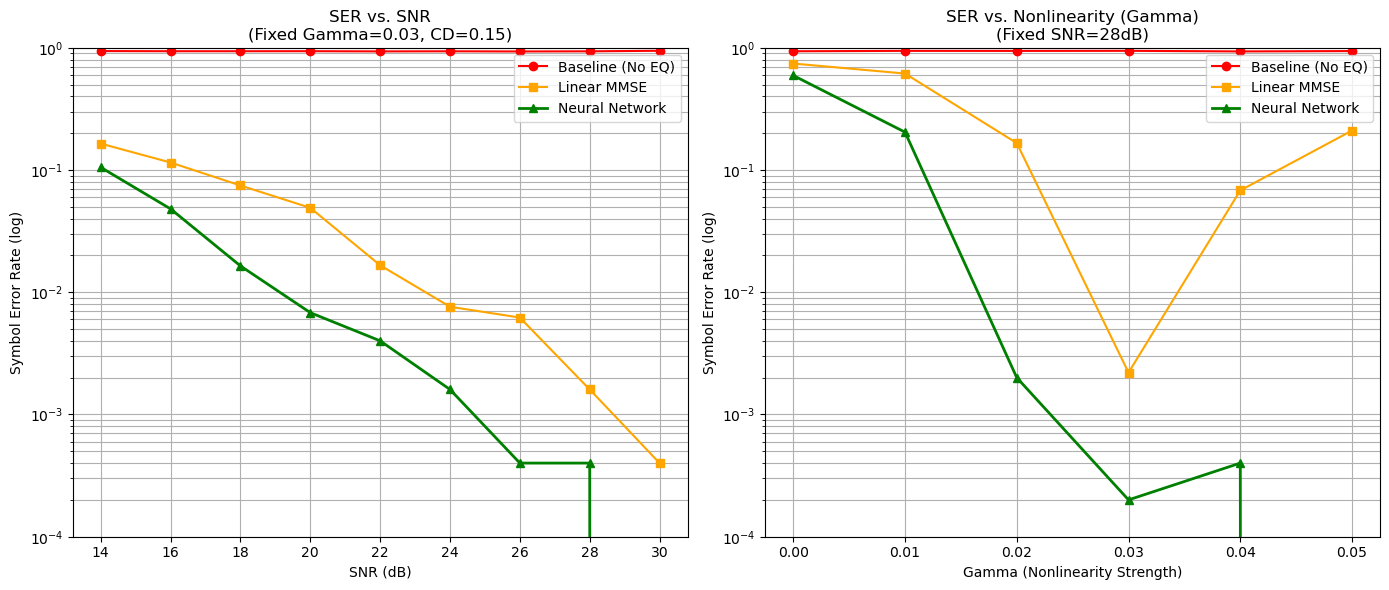

In [39]:
# =============================================================================
# BLOCK 6: CHARACTERIZATION (Generating SER vs. SNR & SER vs. Gamma Curves)
# =============================================================================


# --- CONFIGURATION FOR TESTING ---
TEST_SYMBOLS = 5000  # Enough to get a smooth curve
WINDOW_SIZE = 5
PAD = WINDOW_SIZE // 2

# We need the Helper Function again (to generate fresh data on the fly)
# (Re-using the logic from Block 1 for consistency)
def generate_test_batch(snr, cd, gamma, count):
    rx_raw, tx_raw = simulate_channel(count, snr, cd, gamma)
    
    # Slice into windows
    X_batch = []
    y_batch = []
    
    for i in range(PAD, len(rx_raw) - PAD):
        window = rx_raw[i-PAD : i+PAD+1]
        feat = np.concatenate([window.real, window.imag])
        X_batch.append(feat)
        center_sym = tx_raw[i]
        y_batch.append([center_sym.real, center_sym.imag])
        
    return np.array(X_batch), np.array(y_batch)

# --- 1. SWEEP 1: SER vs. SNR (Robustness to Noise) ---
# Fixed Physics (Medium Difficulty)
FIXED_CD = 0.15     
FIXED_GAMMA = 0.03  
SNR_RANGE = [14, 16, 18, 20, 22, 24, 26, 28, 30]

ser_log_nn_snr = []
ser_log_lmmse_snr = []
ser_log_base_snr = []

print(f"Starting SNR Sweep (Fixed Gamma={FIXED_GAMMA}, CD={FIXED_CD})...")
for snr in SNR_RANGE:
    # A. Generate Data for this specific SNR point
    X_test_sweep, y_test_sweep = generate_test_batch(snr, FIXED_CD, FIXED_GAMMA, TEST_SYMBOLS)
    
    # B. Scale (MUST use the global max_val from training to be fair)
    X_test_scaled = X_test_sweep / max_val
    
    # C. Prepare Ground Truth IDs
    true_ids = get_symbol_id(y_test_sweep[:,0] + 1j * y_test_sweep[:,1])
    
    # D. Baseline (Slicer) Prediction
    rx_center = X_test_sweep[:, 4] + 1j * X_test_sweep[:, 9] # Indices 4/9 are current symbol
    pred_ids_base = get_symbol_id(rx_center)
    ser_base = np.mean(true_ids != pred_ids_base)
    
    # E. Linear MMSE Prediction
    y_pred_lmmse_sc = linear_mmse.predict(X_test_scaled) * max_val
    pred_ids_lmmse = get_symbol_id(y_pred_lmmse_sc[:,0] + 1j * y_pred_lmmse_sc[:,1])
    ser_lmmse = np.mean(true_ids != pred_ids_lmmse)
    
    # F. Neural Network Prediction
    y_pred_nn_sc = model.predict(X_test_scaled, verbose=0) * max_val
    pred_ids_nn = get_symbol_id(y_pred_nn_sc[:,0] + 1j * y_pred_nn_sc[:,1])
    ser_nn = np.mean(true_ids != pred_ids_nn)
    
    # Store results
    ser_log_base_snr.append(ser_base)
    ser_log_lmmse_snr.append(ser_lmmse)
    ser_log_nn_snr.append(ser_nn)
    print(f"  SNR={snr}dB -> Base: {ser_base:.3f}, L-MMSE: {ser_lmmse:.3f}, NN: {ser_nn:.3f}")

# --- 2. SWEEP 2: SER vs. GAMMA (Robustness to Nonlinearity) ---
# Fixed Physics (Clean-ish Signal)
FIXED_SNR = 28  # High SNR to isolate the Kerr effect
FIXED_CD = 0.15
GAMMA_RANGE = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05]

ser_log_nn_gam = []
ser_log_lmmse_gam = []
ser_log_base_gam = []

print(f"\nStarting Gamma Sweep (Fixed SNR={FIXED_SNR}dB)...")
for g in GAMMA_RANGE:
    # A. Generate Data
    X_test_sweep, y_test_sweep = generate_test_batch(FIXED_SNR, FIXED_CD, g, TEST_SYMBOLS)
    
    # B. Scale
    X_test_scaled = X_test_sweep / max_val
    
    # C. Ground Truth
    true_ids = get_symbol_id(y_test_sweep[:,0] + 1j * y_test_sweep[:,1])
    
    # D. Baseline
    rx_center = X_test_sweep[:, 4] + 1j * X_test_sweep[:, 9]
    pred_ids_base = get_symbol_id(rx_center)
    ser_base = np.mean(true_ids != pred_ids_base)
    
    # E. Linear MMSE
    y_pred_lmmse_sc = linear_mmse.predict(X_test_scaled) * max_val
    pred_ids_lmmse = get_symbol_id(y_pred_lmmse_sc[:,0] + 1j * y_pred_lmmse_sc[:,1])
    ser_lmmse = np.mean(true_ids != pred_ids_lmmse)
    
    # F. Neural Network
    y_pred_nn_sc = model.predict(X_test_scaled, verbose=0) * max_val
    pred_ids_nn = get_symbol_id(y_pred_nn_sc[:,0] + 1j * y_pred_nn_sc[:,1])
    ser_nn = np.mean(true_ids != pred_ids_nn)
    
    ser_log_base_gam.append(ser_base)
    ser_log_lmmse_gam.append(ser_lmmse)
    ser_log_nn_gam.append(ser_nn)
    # print(f"  Gamma={g:.3f} -> Base: {ser_base:.3f}, L-MMSE: {ser_lmmse:.3f}, NN: {ser_nn:.3f}")

# --- 3. PLOTTING THE RESULTS ---
plt.figure(figsize=(14, 6))

# Plot 1: SER vs SNR
plt.subplot(1, 2, 1)
plt.semilogy(SNR_RANGE, ser_log_base_snr, 'r-o', label='Baseline (No EQ)')
plt.semilogy(SNR_RANGE, ser_log_lmmse_snr, 'orange', marker='s', label='Linear MMSE')
plt.semilogy(SNR_RANGE, ser_log_nn_snr, 'g-^', linewidth=2, label='Neural Network')
plt.title(f"SER vs. SNR\n(Fixed Gamma={FIXED_GAMMA}, CD={FIXED_CD})")
plt.xlabel("SNR (dB)")
plt.ylabel("Symbol Error Rate (log)")
plt.grid(True, which="both", ls="-")
plt.legend()
plt.ylim(1e-4, 1.0) # Standard BER axis limits

# Plot 2: SER vs Gamma
plt.subplot(1, 2, 2)
plt.semilogy(GAMMA_RANGE, ser_log_base_gam, 'r-o', label='Baseline (No EQ)')
plt.semilogy(GAMMA_RANGE, ser_log_lmmse_gam, 'orange', marker='s', label='Linear MMSE')
plt.semilogy(GAMMA_RANGE, ser_log_nn_gam, 'g-^', linewidth=2, label='Neural Network')
plt.title(f"SER vs. Nonlinearity (Gamma)\n(Fixed SNR={FIXED_SNR}dB)")
plt.xlabel("Gamma (Nonlinearity Strength)")
plt.ylabel("Symbol Error Rate (log)")
plt.grid(True, which="both", ls="-")
plt.legend()
plt.ylim(1e-4, 1.0)

plt.tight_layout()
plt.show()

##  BLOCK 7: WEIGHT QUANTIZATION & ROM GENERATION

In [40]:
# =============================================================================
#  BLOCK 7: WEIGHT QUANTIZATION & ROM GENERATION
# =============================================================================


# --- 1. HARDWARE SPECS (Q4.12 Format) ---
# We chose Q4.12 because your weights are between -3.75 and +2.0
TOTAL_BITS = 16
FRAC_BITS  = 14
SCALE      = 2 ** FRAC_BITS  # 4096
MAX_INT    = (2 ** (TOTAL_BITS-1)) - 1  # +32767
MIN_INT    = -(2 ** (TOTAL_BITS-1))     # -32768

def float_to_fixed(val):
    # 1. Scale
    scaled = val * SCALE
    # 2. Round
    rounded = np.round(scaled)
    # 3. Clip (Saturate)
    clipped = np.clip(rounded, MIN_INT, MAX_INT)
    return clipped.astype(int)

# --- 2. EXTRACT WEIGHTS ---
print("--- Generating ROM Files ---")
if not os.path.exists("rom_files"): os.makedirs("rom_files")

# We iterate through the 3 layers (Hidden1, Hidden2, Output)
layer_names = ["L1", "L2", "L3"]
# Note: Check your model.layers indices. Usually [0, 1, 2] if you have 3 Dense layers.
for i, layer in enumerate(model.layers):
    if "input" in layer.name: continue # Skip Input layer object if present
    
    weights, biases = layer.get_weights()
    
    # Quantize
    w_fixed = float_to_fixed(weights)
    b_fixed = float_to_fixed(biases)
    
    # Save Weights (Flattened: Row by Row)
    # Logic: Verilog will read this into a generic RAM/ROM
    np.savetxt(f"rom_files/{layer_names[i]}_W.txt", w_fixed.flatten(), fmt='%d')
    np.savetxt(f"rom_files/{layer_names[i]}_b.txt", b_fixed.flatten(), fmt='%d')
    print(f"Max Weight Value: {np.max(weights):.4f}")
    print(f"Min Weight Value: {np.min(biases):.4f}")
    
    print(f"Layer {layer_names[i]}: Saved W {w_fixed.shape} and b {b_fixed.shape}")

# Save the Scaling Factor for the next script
print(f"Global Scaling Factor (max_val): {max_val:.4f}")

--- Generating ROM Files ---
Max Weight Value: 1.4046
Min Weight Value: -0.8262
Layer L1: Saved W (10, 32) and b (32,)
Max Weight Value: 0.6039
Min Weight Value: -0.5029
Layer L2: Saved W (32, 32) and b (32,)
Max Weight Value: 1.2623
Min Weight Value: -0.0462
Layer L3: Saved W (32, 2) and b (2,)
Global Scaling Factor (max_val): 5.0000


# PART 2: GOLDEN MODEL 

## Python model

### --- 1. SETUP ---

In [41]:
# =============================================================================
# PART 2: GOLDEN MODEL (FIXED: 32-bit Accumulator)
# =============================================================================

# --- 1. SETUP ---
FRAC_BITS = 14
SCALE     = 1 << FRAC_BITS # 4096
MAX_16    = 32767
MIN_16    = -32768

# Load Weights (Same as before)
def load_rom(fname, shape):
    return np.loadtxt(f"rom_files/{fname}.txt", dtype=int).reshape(shape)

W1 = load_rom("L1_W", (10, 32)) 
b1 = load_rom("L1_b", (32,))
W2 = load_rom("L2_W", (32, 32))
b2 = load_rom("L2_b", (32,))
W3 = load_rom("L3_W", (32, 2))
b3 = load_rom("L3_b", (2,))


### --- 2. CORRECTED HARDWARE LOGIC ---

In [42]:

# --- 2. CORRECTED HARDWARE LOGIC ---

def neuron_block(input_bus, w_ram, b_val, use_relu):
    """
    Simulates a Neuron with a Wide Accumulator.
    """
    # 1. Initialize Accumulator (Internal 32-bit or 48-bit register)
    # We start with the Bias (shifted to match the fractional alignment if needed)
    # Note: Weights/Inputs are Q4.12. Product is Q8.24.
    # We want to keep precision. 
    # Standard DSP approach: 
    #   acc starts at 0.
    #   add products.
    #   add bias at the end (aligned).
    
    accumulator = 0 
    
    # 2. MAC Loop (Using Full Precision Internally)
    for k in range(len(input_bus)):
        # A. Fetch
        val_in = int(input_bus[k])
        weight = int(w_ram[k])
        
        # B. Multiply (Result is Q8.24)
        # 16-bit * 16-bit = 32-bit
        product = val_in * weight 
        
        # C. Accumulate (No clipping yet!)
        accumulator += product

    # 3. Scale Down (The "Quantization" Step)
    # We currently have Q8.24 format in the accumulator.
    # We need to bring it back to Q4.12 for the next layer.
    # Shift right by 12 bits.
    accumulator = accumulator >> FRAC_BITS
    
    # 4. Add Bias (Bias is already Q4.12)
    accumulator += int(b_val)
    
    # 5. Activation (ReLU)
    if use_relu and accumulator < 0:
        accumulator = 0
        
    # 6. Final Saturation (Clip to 16-bit Output)
    # NOW we clip, because this wire goes to the next layer
    if accumulator > MAX_INT: accumulator = MAX_INT
    if accumulator < MIN_INT: accumulator = MIN_INT
        
    return accumulator


### --- 3. SIMULATION LOOP ---

In [ ]:

# --- 3. SIMULATION LOOP ---

# Prepare Test Data (Unscaled inputs)
N_TEST = 1000
X_input_raw = X_test[:N_TEST] * max_val  
y_target_raw = y_test[:N_TEST] * max_val

# ADC Model
# Ensure inputs are 16-bit ints
input_stream = np.round((X_input_raw / max_val) * SCALE).astype(int)
input_stream = np.clip(input_stream, MIN_INT, MAX_INT)

hw_outputs_complex = []

print(f"Running Fixed Golden Model on {N_TEST} symbols...")

# Debug: Print first neuron internals to check ranges
debug_once = True

for t in range(N_TEST):
    current_window = input_stream[t] 
    
    # Layer 1
    L1_out = []
    for n in range(32): 
        val = neuron_block(current_window, W1[:, n], b1[n], use_relu=True)
        L1_out.append(val)
    
    # Layer 2
    L2_out = []
    for n in range(32): 
        val = neuron_block(L1_out, W2[:, n], b2[n], use_relu=True)
        L2_out.append(val)
        
    # Output Layer
    L3_out = []
    for n in range(2): 
        val = neuron_block(L2_out, W3[:, n], b3[n], use_relu=False)
        L3_out.append(val)
        
    # Debug Print for first sample
    if debug_once:
        print(f"DEBUG Sample 0:")
        print(f"  Input[0]: {current_window[0]}")
        print(f"  L1_Out[0]: {L1_out[0]}")
        print(f"  L2_Out[0]: {L2_out[0]}")
        print(f"  Final Out: {L3_out}")
        debug_once = False

    # DAC Model
    re_volt = (L3_out[0] / SCALE) * max_val
    im_volt = (L3_out[1] / SCALE) * max_val
    hw_outputs_complex.append(re_volt + 1j*im_volt)

hw_outputs_complex = np.array(hw_outputs_complex)


Running Fixed Golden Model on 1000 symbols...
DEBUG Sample 0:
  Input[0]: -668
  L1_Out[0]: 0
  L2_Out[0]: 6955
  Final Out: [-3282, -9888]


### --- 4. VERIFICATION ---


=== GOLDEN MODEL RESULTS ===
Simulated Hardware SER: 0.01200


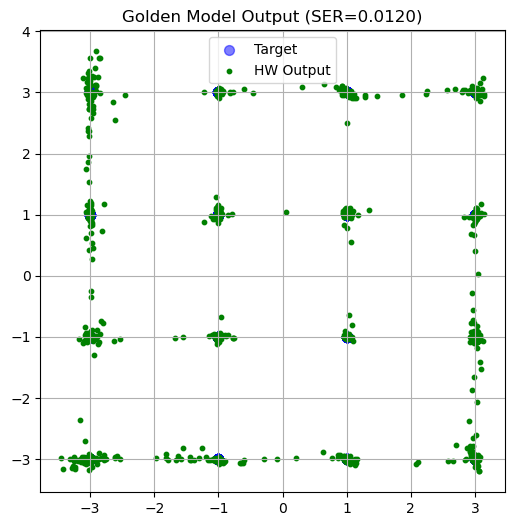

In [44]:

# --- 4. VERIFICATION ---

def get_symbol_id(complex_data):
    thresholds = np.array([-2, 0, 2])
    re_id = np.digitize(complex_data.real, thresholds)
    im_id = np.digitize(complex_data.imag, thresholds)
    return re_id * 4 + im_id

target_complex = y_target_raw[:,0] + 1j*y_target_raw[:,1]
true_ids = get_symbol_id(target_complex)
pred_ids_hw = get_symbol_id(hw_outputs_complex)
ser = np.mean(true_ids != pred_ids_hw)

print(f"\n=== GOLDEN MODEL RESULTS ===")
print(f"Simulated Hardware SER: {ser:.5f}")

plt.figure(figsize=(6,6))
plt.scatter(target_complex.real, target_complex.imag, c='blue', s=50, alpha=0.5, label='Target')
plt.scatter(hw_outputs_complex.real, hw_outputs_complex.imag, c='green', s=10, label='HW Output')
plt.title(f"Golden Model Output (SER={ser:.4f})")
plt.legend(); plt.grid(True)
plt.show()

## C++ Model

### BLOCK A (FIXED): ROBUST FILE GENERATION

In [50]:
# =============================================================================
# BLOCK A (FIXED): ROBUST FILE GENERATION
# =============================================================================
import numpy as np
import os
import shutil

# --- CONFIGURATION ---
FRAC_BITS = 14
SCALE     = 1 << FRAC_BITS
MAX_INT   = 32767
MIN_INT   = -32768
FIXED_MAX_VAL = 5.0

# 1. CLEANUP (Delete old files to prevent confusion)
if os.path.exists("sim_data"):
    shutil.rmtree("sim_data")
os.makedirs("sim_data")
print("Created clean /sim_data/ directory.")

def save_hdl(name, data):
    path = f"sim_data/{name}"
    np.savetxt(path, data.flatten(), fmt='%d')
    print(f" -> Saved {name}")

# --- 2. EXPORT WEIGHTS (With Manual Counter) ---
print("Exporting Weights...")
layer_count = 1  # Start counting at 1 (L1, L2, L3)

for layer in model.layers:
    # Skip Input layers, Flatten layers, etc. Only want Dense.
    if "dense" not in layer.name: 
        continue
    
    W, b = layer.get_weights()
    
    # Quantize
    W_q = np.clip(np.round(W * SCALE), MIN_INT, MAX_INT).astype(int)
    b_q = np.clip(np.round(b * SCALE), MIN_INT, MAX_INT).astype(int)
    
    # Force names: L1, L2, L3
    save_hdl(f"L{layer_count}_W.txt", W_q)
    save_hdl(f"L{layer_count}_b.txt", b_q)
    
    layer_count += 1

# --- 3. EXPORT STIMULI (Same as before) ---
print("Exporting Stimuli...")
N_SIM = 2000
X_slice = X_test[:N_SIM]
y_slice = y_test[:N_SIM]

# Input (ADC Quantization)
X_volts = X_slice * FIXED_MAX_VAL
X_int = np.round(X_volts * (SCALE / FIXED_MAX_VAL)).astype(int)
X_int = np.clip(X_int, MIN_INT, MAX_INT)
save_hdl("input_stimuli.txt", X_int)

# Target (Float Voltage for Verification)
y_volts = y_slice * FIXED_MAX_VAL
np.savetxt("sim_data/target_voltages.txt", y_volts, fmt='%.6f')

print("\n[SUCCESS] Files generated. Run './equalizer_sim' now.")

Created clean /sim_data/ directory.
Exporting Weights...
 -> Saved L1_W.txt
 -> Saved L1_b.txt
 -> Saved L2_W.txt
 -> Saved L2_b.txt
 -> Saved L3_W.txt
 -> Saved L3_b.txt
Exporting Stimuli...
 -> Saved input_stimuli.txt

[SUCCESS] Files generated. Run './equalizer_sim' now.


### BLOCK B (UNIFIED): VISUALIZATION, SER & BER (Gray Coded)

--- ANALYZING C++ RESULTS (SER + BER) ---
Total Symbols: 2000
Symbol Errors: 19 	(SER: 0.00950)
Bit Errors:    19 	(BER: 0.00237)


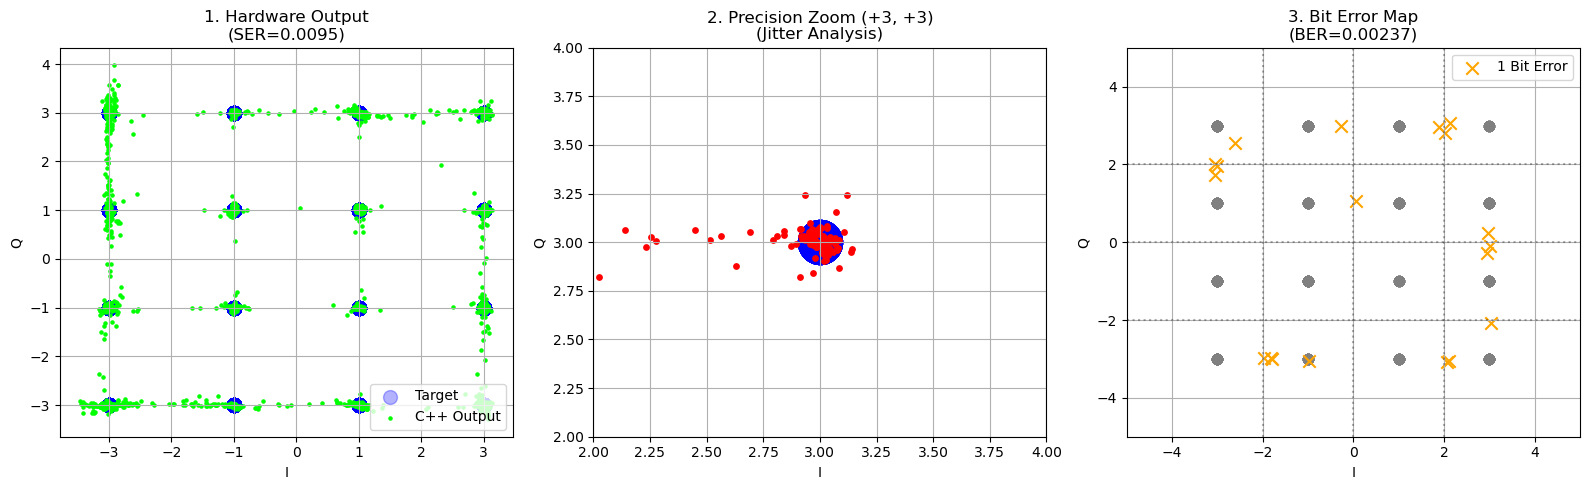

In [ ]:
# =============================================================================
# BLOCK B (UNIFIED): VISUALIZATION, SER & BER (Gray Coded)
# =============================================================================
import matplotlib.pyplot as plt
import numpy as np

# --- 1. SETTINGS (Must match Block A & C++) ---
FRAC_BITS = 14
SCALE     = 1 << FRAC_BITS
FIXED_MAX_VAL = 5.0

print("--- ANALYZING C++ RESULTS (SER + BER) ---")

# --- 2. LOAD DATA ---
try:
    # Load C++ Integer Output
    cpp_int = np.loadtxt("sim_data/output_integers.txt")
    # Load Python Float Targets
    target_volt = np.loadtxt("sim_data/target_voltages.txt")
except IOError:
    print("[ERR] Files not found. Did you run the C++ executable?")
    raise

# --- 3. DAC MODEL (Int -> Voltage) ---
# Formula: (Integer / 16384) * 5.0
cpp_volt = (cpp_int / SCALE) * FIXED_MAX_VAL

# Convert to Complex
cpp_complex = cpp_volt[:, 0] + 1j * cpp_volt[:, 1]
target_complex = target_volt[:, 0] + 1j * target_volt[:, 1]

# --- 4. GRAY CODING LOGIC ---
# Standard Gray Mapping for 4-PAM (used in 16-QAM):
# Level -3 (< -2) -> 00
# Level -1 (<  0) -> 01
# Level +1 (<  2) -> 11
# Level +3 (>  2) -> 10

def voltage_to_gray_bits(voltage_val):
    if voltage_val < -2: return np.array([0, 0]) # Level -3
    if voltage_val < 0:  return np.array([0, 1]) # Level -1
    if voltage_val < 2:  return np.array([1, 1]) # Level +1
    return np.array([1, 0])                      # Level +3

def symbol_to_bits(c_val):
    # Concatenate Real bits and Imag bits (4 bits total)
    bits_i = voltage_to_gray_bits(c_val.real)
    bits_q = voltage_to_gray_bits(c_val.imag)
    return np.concatenate([bits_i, bits_q])

# --- 5. CALCULATE ERRORS (The Loop) ---
total_bits = 0
bit_errors = 0
symbol_errors = 0
error_locs = []       # Where did errors happen?
error_magnitudes = [] # How many bits were wrong?

num_samples = len(target_complex)

for i in range(num_samples):
    # A. Get Bits
    target_bits = symbol_to_bits(target_complex[i])
    pred_bits   = symbol_to_bits(cpp_complex[i])
    
    # B. Count Bit Mismatches
    diff = np.sum(target_bits != pred_bits)
    total_bits += 4
    bit_errors += diff
    
    # C. Count Symbol Mismatches
    if diff > 0:
        symbol_errors += 1
        error_locs.append(cpp_complex[i])
        error_magnitudes.append(diff)

# Statistics
ber = bit_errors / total_bits
ser = symbol_errors / num_samples

print(f"{'='*30}")
print(f"Total Symbols: {num_samples}")
print(f"Symbol Errors: {symbol_errors} \t(SER: {ser:.5f})")
print(f"Bit Errors:    {bit_errors} \t(BER: {ber:.5f})")
print(f"{'='*30}")

# --- 6. PLOTTING (3-Panel View) ---
plt.figure(figsize=(16, 5))

# Plot 1: Full Constellation (Overview)
plt.subplot(1, 3, 1)
plt.scatter(target_complex.real, target_complex.imag, c='blue', s=100, alpha=0.3, label='Target')
plt.scatter(cpp_complex.real, cpp_complex.imag, c='lime', s=5, label='C++ Output')
plt.title(f"1. Hardware Output\n(SER={ser:.4f})")
plt.xlabel("I"); plt.ylabel("Q")
plt.legend(loc='lower right')
plt.grid(True)

# Plot 2: Zoom (Precision)
plt.subplot(1, 3, 2)
plt.scatter(target_complex.real, target_complex.imag, c='blue', s=1000, alpha=0.1)
plt.scatter(cpp_complex.real, cpp_complex.imag, c='red', s=15)
plt.xlim(2, 4); plt.ylim(2, 4)
plt.title("2. Precision Zoom (+3, +3)\n(Jitter Analysis)")
plt.xlabel("I"); plt.ylabel("Q")
plt.grid(True)

# Plot 3: Bit Error Heatmap
plt.subplot(1, 3, 3)
# Draw faint grid of correct points
plt.scatter(target_complex.real, target_complex.imag, c='gray', alpha=0.1, s=50)

if len(error_locs) > 0:
    err_complex = np.array(error_locs)
    err_mags = np.array(error_magnitudes)
    
    # Orange 'X' for 1-bit errors (Gray Code doing its job)
    mask1 = err_mags == 1
    if np.any(mask1):
        plt.scatter(err_complex[mask1].real, err_complex[mask1].imag, 
                    c='orange', marker='x', s=80, label="1 Bit Error")
    
    # Red Diamond for 2+ bit errors (Catastrophic errors)
    mask2 = err_mags > 1
    if np.any(mask2):
        plt.scatter(err_complex[mask2].real, err_complex[mask2].imag, 
                    c='red', marker='D', s=80, label="Multi-Bit Error")
    plt.legend()
else:
    plt.text(0, 0, "PERFECT TRANSMISSION\nNO ERRORS", ha='center', fontsize=12, color='green')

# Draw Slicer Lines
plt.axvline(-2, c='k', ls=':', alpha=0.3); plt.axvline(0, c='k', ls=':', alpha=0.3); plt.axvline(2, c='k', ls=':', alpha=0.3)
plt.axhline(-2, c='k', ls=':', alpha=0.3); plt.axhline(0, c='k', ls=':', alpha=0.3); plt.axhline(2, c='k', ls=':', alpha=0.3)

plt.title(f"3. Bit Error Map\n(BER={ber:.5f})")
plt.xlabel("I"); plt.ylabel("Q")
plt.xlim(-5, 5); plt.ylim(-5, 5)
plt.grid(True)

plt.tight_layout()
plt.show()